In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/pf


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import torch
import numpy as np

from scipy import ndimage

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

## Load a model

In [4]:
from peaknet.methods.unet import UNet
from peaknet.model        import ConfigPeakFinderModel, PeakFinderModel

In [5]:
base_channels = 8
method = UNet( in_channels = 1, out_channels = 1, base_channels = base_channels )
config_peakfinder = ConfigPeakFinderModel( method = method, 
                                           focal_alpha = 0.8,
                                           focal_gamma = 2.0 )
model = PeakFinderModel(config_peakfinder)
model.init_params()    # w/ random weights

In [6]:
timestamp = "2022_1101_1429_21"
model.init_params(from_timestamp = timestamp)   # Run this will load a pre-trained model

In [7]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = torch.nn.DataParallel(model.method).to(device)

## Example

In [8]:
# Load an image
test_img = torch.load('test.img')
test_img = torch.tensor(test_img).to(device)    # Load data to gpu or cpu
test_img = test_img[None, None]    # An infrastructure code to run the model
test_img = (test_img - test_img.mean()) / test_img.std()    # Variance normailzation

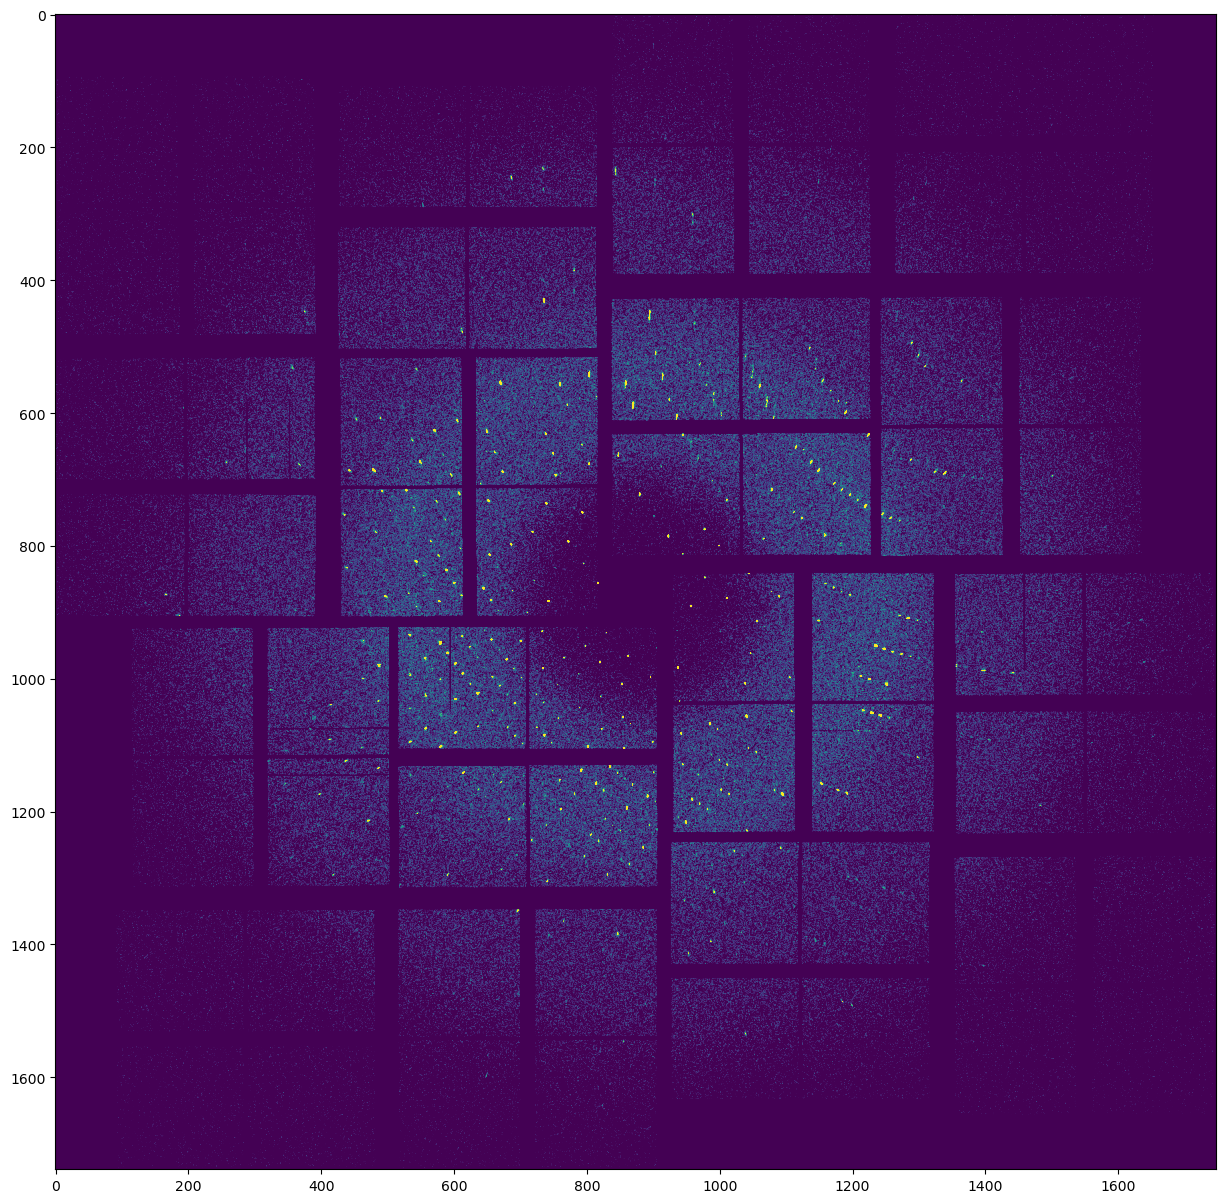

In [9]:
# Check out what it looks like
plt.figure(figsize=(20,15))
data = test_img[0, 0].cpu().detach().numpy()
vmin = data.mean()
#data = data[1200:1400, 50:250]
vmax = vmin + 4 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)

In [10]:
# Make prediction...
model.eval()
with torch.no_grad():
    fmap = model.forward(test_img)

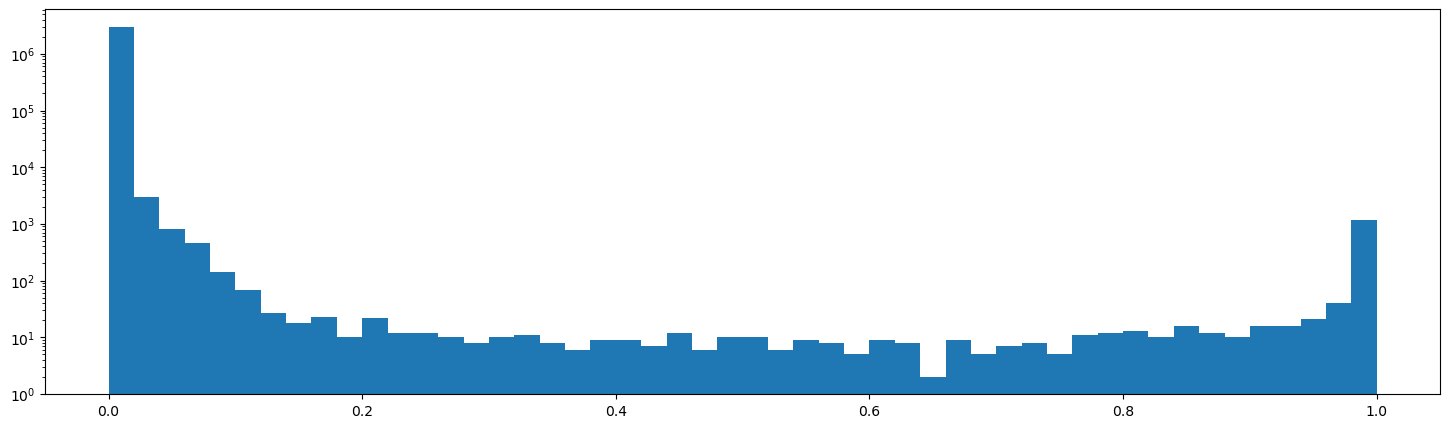

In [11]:
# Sanity check the histogram...
plt.figure(figsize=(18,5))
data = fmap[0, 0].sigmoid().cpu().detach().numpy()
plt.hist(data.reshape(-1), bins = 50);
plt.yscale('log')
# plt.xlim(-2e2,3e2);

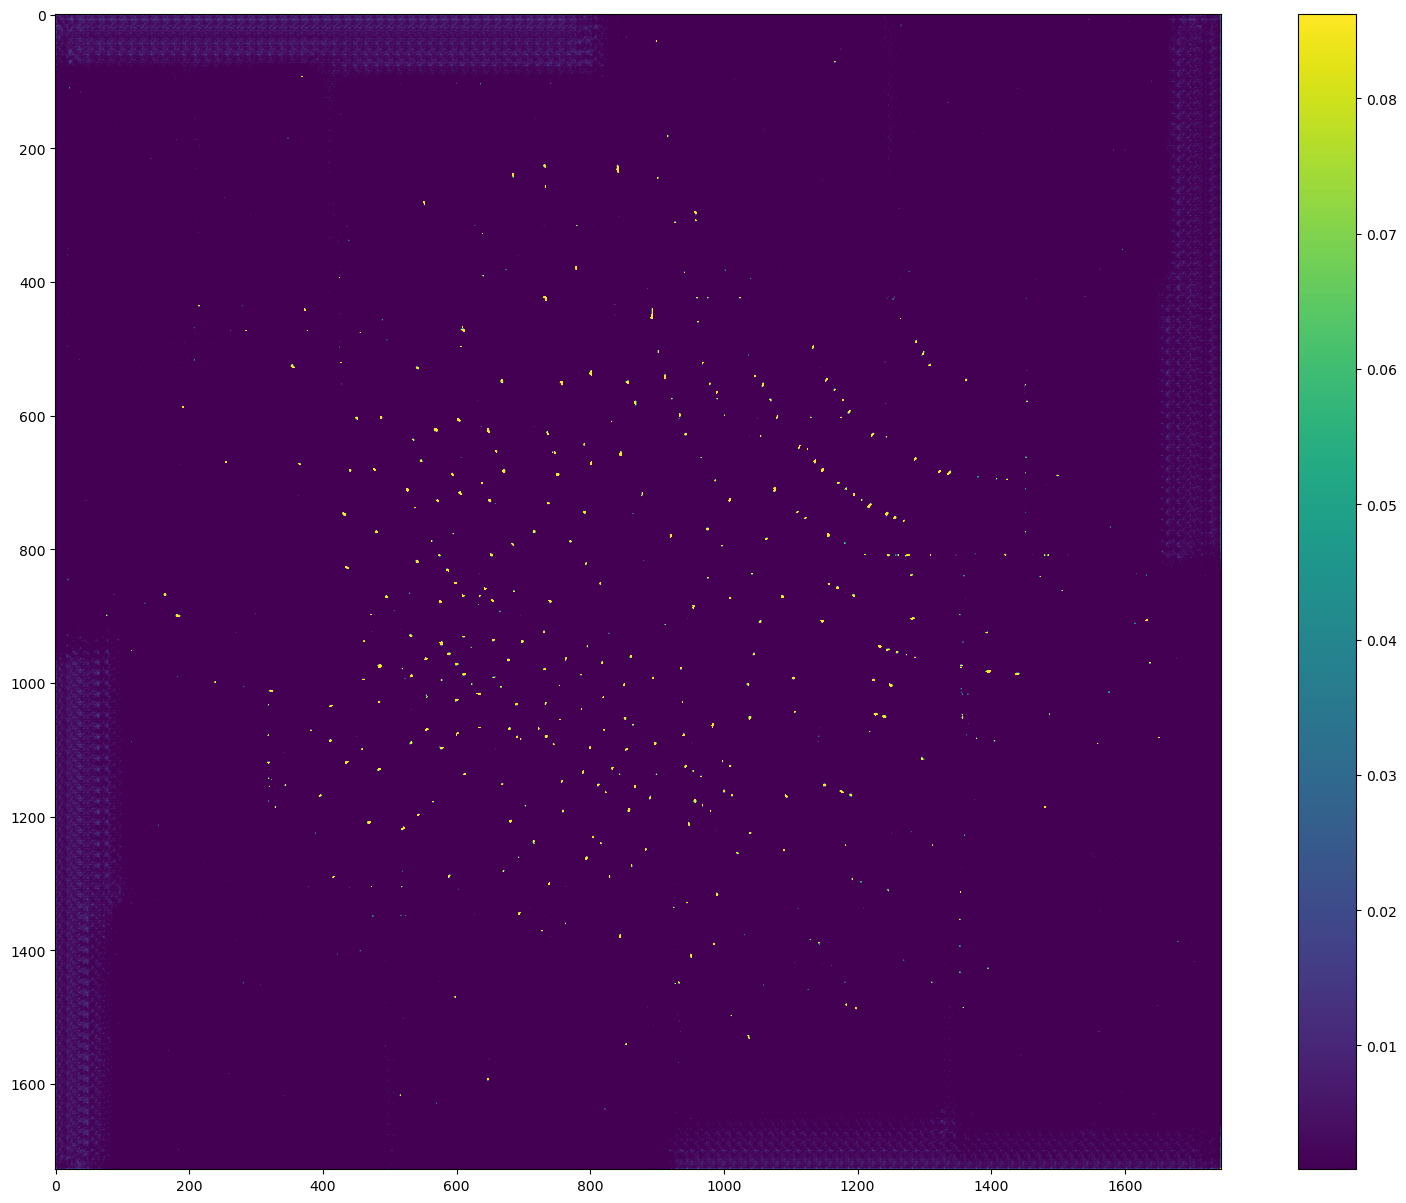

In [12]:
# Visualze the peaks in the form of the feature map
plt.figure(figsize=(20,15))
data = fmap[0, 0].sigmoid().cpu().detach().numpy()
vmin = data.mean()
vmax = vmin + 4 * data.std()

# data[data < 0.9] = 0
# data[~(data < 0.9)] = 1

plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

In [13]:
# Featch the feature map
data = fmap[0, 0].sigmoid().cpu().detach().numpy()

# Threshold the result
threshold = 0.8
data[data < threshold] = 0
data[~(data < threshold)] = 1

# Put box on peaks...
structure = np.ones((3, 3), dtype=bool)
peak_labeled, num_peak = ndimage.label(data, structure)

peak_pos_list = ndimage.center_of_mass(data, peak_labeled, range(1, num_peak))

In [14]:
# How many peaks found???
len(peak_pos_list)

333

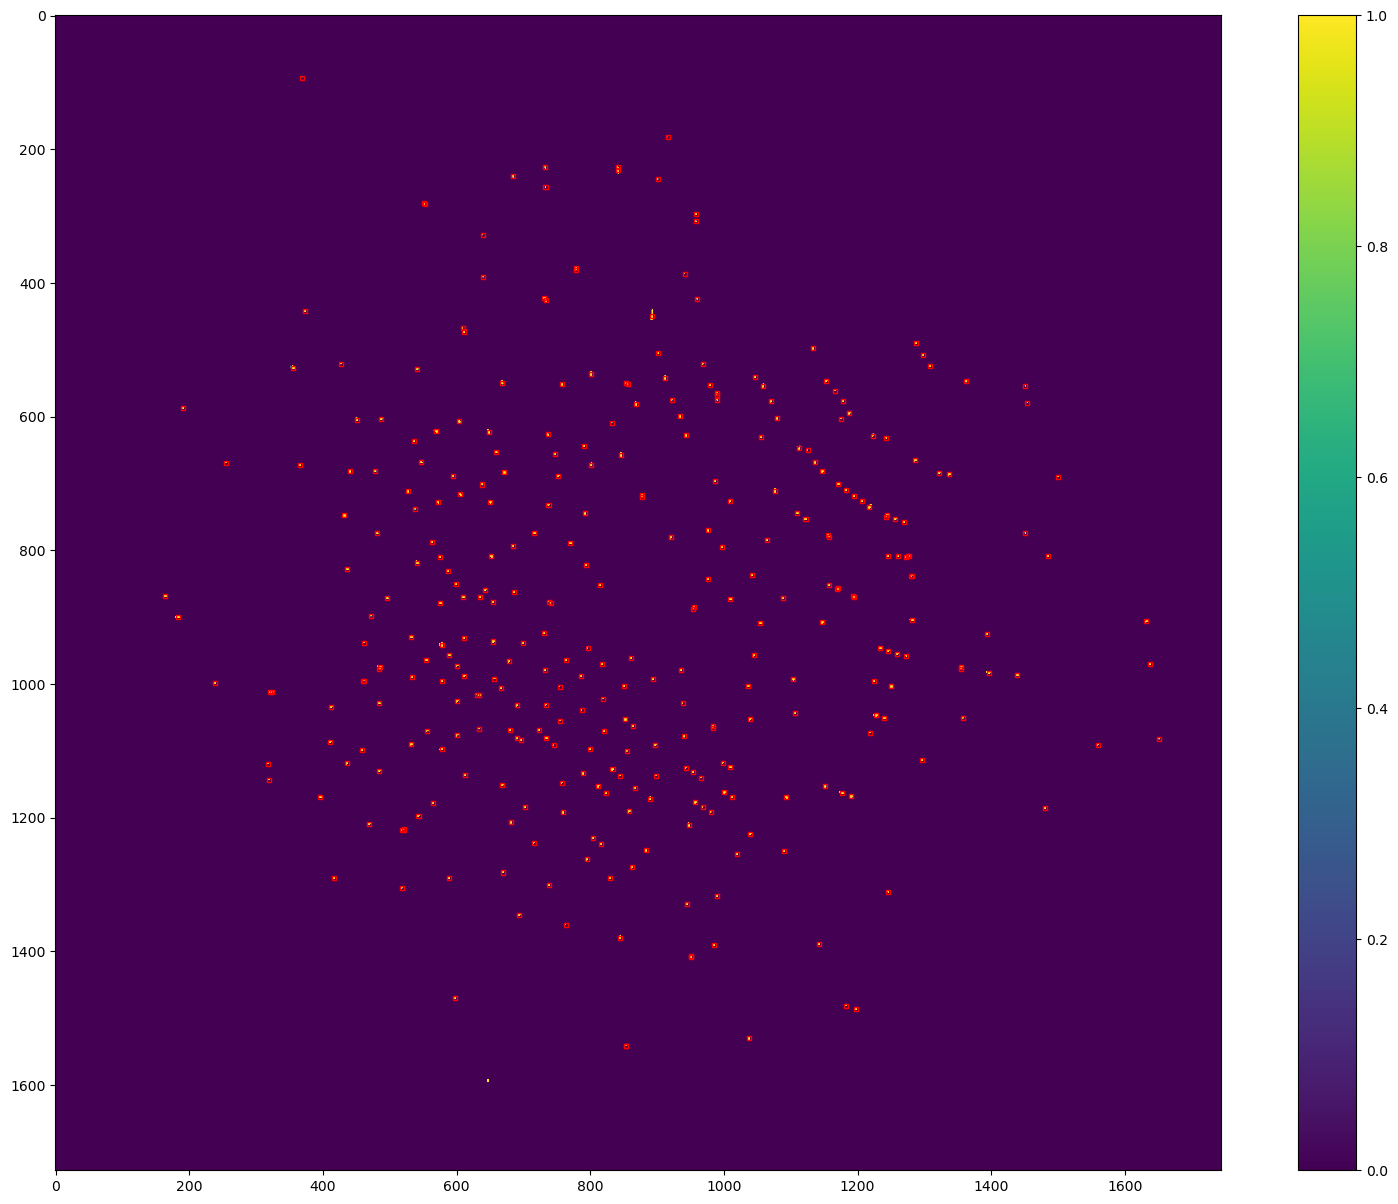

In [15]:
# Label peak by using boxes...
# Visualze the labeled peak
fig = plt.figure(figsize=(20,15))
plt.imshow(peak_labeled, vmin = 0, vmax = 1)
plt.colorbar()

# Add box
offset = 3
linewidth = 1
for y, x in peak_pos_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x - offset
    y_bottom_left = y - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = linewidth, 
                                 edgecolor = 'red', 
                                 facecolor='none')
    fig.gca().add_patch(rec_obj)

fig.gca().add_patch(rec_obj)
# plt.xlim(600,1000)
# plt.ylim(150,500)